# Figures for Physical Insights from the Multidecadal Prediction of North Atlantic Sea Surface Temperature Variability Using Explainable Neural Networks (Poster Version)
Glenn Liu, Peidong Wang, Young-Oh Kwon

This notebook contains code used to generate the main figures (or figure components) of the manuscript.
To generate the figures, check to make sure the required files described in the **Input** section for each figure are present.

### Table of Contents
1. Figure 1: Example Predictors and Target for FNN
2. Figure 2: Mean Accuracy by Leadtime 
3. Figure 3: Relevance Composites for correct NASST+ predictions (and Figure S5 and S6)
4. Figure 4: Class Prediction Count by Year for HadISST (and Figure S7)
5. Figure S1: Validation Accuracy for FNN Hyperparameter Testing
6. Figure S2: FNN4 vs FNN6 Test Accuracy
7. Figure S3: Validation Accuracy for CNN Hyperparameter Testing

In [1]:
# Import Packages

import sys
import numpy as np
import os
import time
import tqdm
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset,Dataset
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import glob
import copy
import xarray as xr
import itertools

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [3]:
# User Edits
darkmode        = True


# Other paths
datpath          = "../../results_manuscript/"
figpath          = "../../results_poster/"#"../../results_sls_talk/"
#datpath          = "../../results_presentation/"  

# Custom Module Packages
amvpath          = "/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/00_Commons/03_Scripts/amv/"
pytorch_lrp_path = "/Users/gliu/Downloads/02_Research/03_Code/github/Pytorch-LRP-master/"

In [4]:
# Import custom packages and other modules

# Import general utilities from amv module
sys.path.append(amvpath)
import proc,viz

# Import packages specific to predict_amv
cwd = os.getcwd()
sys.path.append(cwd+"/../")
import predict_amv_params as pparams
import train_cesm_params as train_cesm_params
import amv_dataloader as dl
import amvmod as am

# LRP Methods
sys.path.append(pytorch_lrp_path)
from innvestigator import InnvestigateModel

In [5]:
%load_ext autoreload
%autoreload 2
# Cell Magic for reloading

In [6]:
# Load some additional variables
bbox         = pparams.bbox
class_colors = pparams.class_colors


In [7]:
# Set up plotting parameters
if darkmode is True:
    plt.style.use('dark_background')
    transparent= True
    dfcol      = "w"
    dfcol_r    = "k"
else:
    plt.style.use('default')
    transparent= False
    dfcol      = "k"
    dfcol_r    = "w"
    
pubready = False # Set to True to Save EPS format versions of figures

In [27]:
# AGU Poster Parameters (WHOI Template)

darkblue  = np.array([4,30,65])/255#"041E41"
lightblue = np.array([0,169,224])/255 #"00A9E0" 

## 1. Figure 1: Example Predictors and Target

The figure was assembeled in Inkscape. This notebook generates an example of the predictors and AMV Index used for the prediction

Inputs:
 - Predictors processed by \[prep_data_byvariable.py\], located in [datpath]/Predictors/
 - Targets processed by \[prepare_regional_targets.py\], located in [datpath]/Targets/

Contents:
1. User Edits
2. Load in data (target and predictors)
3. Visualize Index (Prediction Target)
4. Visualize Predictors

In [9]:
# User Edits
varnames     = ["SST","SLP","SSS","SSH"]
expdir       = "FNN4_128_SingleVar_PaperRun"#"FNN6_128_PaperRun" #"FNN4_128_SingleVar_PaperRun" # Experiment Directory Name
datpath_pred = "%sPredictors/" % datpath
datpath_targ = "%sTargets/" % datpath
eparams      = train_cesm_params.train_params_all[expdir]
leads        = np.arange(0,26,1)

# Load some experiment parameters
norm         = eparams['norm']
ens          = eparams['ens']

In [10]:
# Load target and data
# --------------------
# Load data + target
# Load predictor and labels, lat/lon, cut region
target         = dl.load_target_cesm(detrend=eparams['detrend'],region=eparams['region'],norm=norm,datpath=datpath_targ)
data,lat,lon   = dl.load_data_cesm(varnames,eparams['bbox'],detrend=eparams['detrend'],return_latlon=True,datpath=datpath_pred)

# Make a mask and apply
limask                         = dl.load_limask(bbox=eparams['bbox'])
data                           = data * limask[None,None,None,:,:]  # NaN Points to Zero

# Normalize data
nchannels = data.shape[0]
# *** Note, doing this for each channel, but in reality, need to do for all channels
for ch in range(nchannels):
    std_var = np.nanstd(data[ch,...])
    mu_var = np.nanmean(data[ch,...])
    data[ch,...] = (data[ch,...] - mu_var)/std_var

# Change nan points to zero
data[np.isnan(data)] = 0 

# Determine Target Classes
# ------------------------
# Set exact threshold value
std1         = target.std(1).mean() * eparams['thresholds'][1] # Multiple stdev by threshold value 
if eparams['quantile'] is False:
    thresholds_in = [-std1,std1]
else:
    thresholds_in = eparams['thresholds']

# Classify AMV Events
target_class = am.make_classes(target.flatten()[:,None],thresholds_in,exact_value=True,reverse=True,quantiles=eparams['quantile'])
target_class = target_class.reshape(target.shape)

Class 2 Threshold is y <= -0.37 
Class 1 Threshold is -0.37 < y <= 0.37 
Class 0 Threshold is y > 0.37 


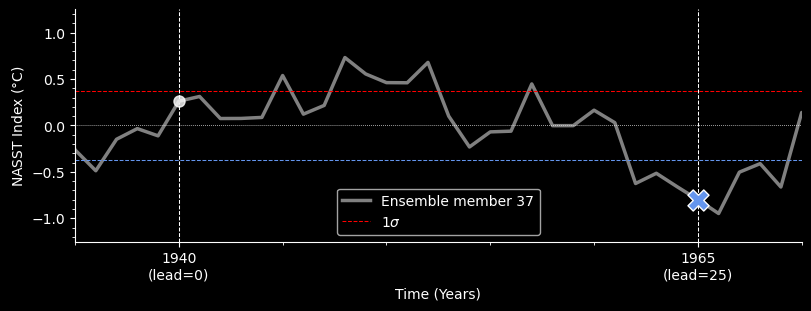

In [11]:
# Visualize the NASST Index

e       = 36

lead0   = 1940
N       = 25

startyr = 1920
yrs     = np.arange(startyr,startyr+target.shape[1])

# Get lead0 and leadN indices
ipred   = np.where(yrs==lead0)[0][0]
ilabel  = ipred+N
lead1   = lead0+N
xtk     = [lead0,lead1]
xtklabs = (str(lead0) + "\n(lead=0)",str(lead1)+"\n(lead=%i)"%N) 

fig,ax= plt.subplots(1,1,figsize=(8,3),constrained_layout=True)
ax.plot(yrs,target[e,:],c="gray",label="Ensemble member %02i" % (e+1),lw=2.5)

ax.spines[['right', 'top']].set_visible(False)

ax.axhline([0],ls="dotted",color=dfcol,lw=0.55)
ax.axhline([-std1],ls="dashed",color="cornflowerblue",lw=0.75,label="")
ax.axhline([std1],ls="dashed",color="red",lw=0.75,label="1$\sigma$")
ax.legend(loc="lower center")
ax.minorticks_on()
ax.set_ylim([-1.25,1.25])
ax.set_xlim([1935,1970])
ax.set_ylabel("NASST Index ($\degree$C)")
ax.set_xlabel("Time (Years)")

# Plot sample leadtimes for prediction
ax.set_xticks(xtk,labels=xtklabs) # Label lead 0 and lead N
ax.scatter(lead0,target[e,ipred],marker=".",color=dfcol,label="",
        s=255,edgecolors=dfcol,zorder=3,alpha=0.8) # Plot lead0
ax.axvline([lead0],color=dfcol,ls="dashed",lw=0.75,zorder=1)
ax.scatter(lead1,target[e,ilabel],marker="X",color="cornflowerblue",label="",
        s=230,edgecolors=dfcol,zorder=3) # Plot lead0
ax.axvline([lead1],color=dfcol,ls="dashed",lw=0.75,zorder=1)

if figpath is not None:
    savename = "%sNASST_Prediction_Example_Ens%i_Start%04i_lead%02i.svg" % (figpath,e+1,lead0,N)
    plt.savefig(savename,transparent=transparent,dpi=300)

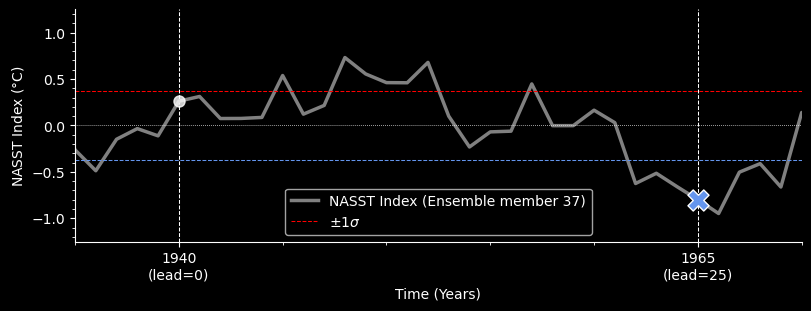

In [33]:
# Same as above, but looped to show the animations
# Visualize the NASST Index

e       = 36

lead0   = 1940
N       = 25

startyr = 1920
yrs     = np.arange(startyr,startyr+target.shape[1])

# Get lead0 and leadN indices
ipred   = np.where(yrs==lead0)[0][0]
ilabel  = ipred+N
lead1   = lead0+N
xtk     = [lead0,lead1]
xtklabs = (str(lead0) + "\n(lead=0)",str(lead1)+"\n(lead=%i)"%N) 

fig,ax= plt.subplots(1,1,figsize=(8,3),constrained_layout=True)
ax.plot(yrs,target[e,:],c="gray",label="NASST Index (Ensemble member %02i)" % (e+1),lw=2.5)

ax.spines[['right', 'top']].set_visible(False)

ax.axhline([0],ls="dotted",color=dfcol,lw=0.55)
ax.axhline([-std1],ls="dashed",color="cornflowerblue",lw=0.75,label="")
ax.axhline([std1],ls="dashed",color="red",lw=0.75,label="$\pm$1$\sigma$")
ax.legend(loc="lower center")
ax.minorticks_on()
ax.set_ylim([-1.25,1.25])
ax.set_xlim([1935,1970])
ax.set_ylabel("NASST Index ($\degree$C)")
ax.set_xlabel("Time (Years)")

# Plot sample leadtimes for prediction
ax.set_xticks(xtk,labels=xtklabs) # Label lead 0 and lead N
ax.scatter(lead0,target[e,ipred],marker=".",color=dfcol,label="",
        s=255,edgecolors=dfcol,zorder=3,alpha=0.8) # Plot lead0
ax.axvline([lead0],color=dfcol,ls="dashed",lw=0.75,zorder=1)
ax.scatter(lead1,target[e,ilabel],marker="X",color="cornflowerblue",label="",
        s=230,edgecolors=dfcol,zorder=3) # Plot lead0
ax.axvline([lead1],color=dfcol,ls="dashed",lw=0.75,zorder=1)

if figpath is not None:
    savename = "%sNASST_Prediction_Example_Ens%i_Start%04i_lead%02i.svg" % (figpath,e+1,lead0,N)
    plt.savefig(savename,transparent=transparent,dpi=300)

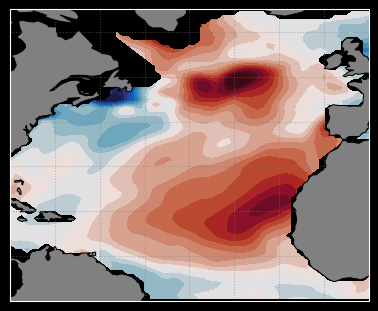

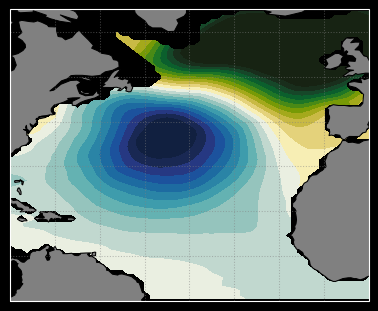

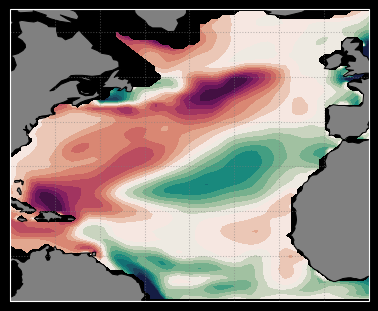

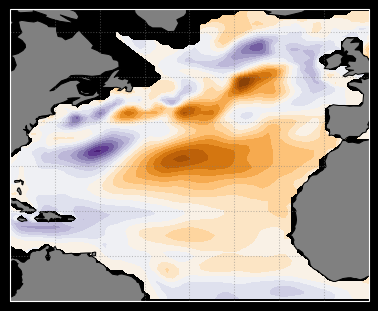

In [56]:
# Visualize Predictor values


consistent_mask = np.sum(data,(0,1,2)) == 0

use_contour = True
nvars = len(varnames)
vlims = [-2,2]
vcmap = ["cmo.balance","cmo.delta","cmo.curl","PuOr_r"]
varunits = [("normalized"),] * nvars
for v in range(nvars):
    
    fig,ax = plt.subplots(1,1,subplot_kw={'projection':ccrs.PlateCarree(0)},
                          constrained_layout=True,figsize=(4,3))
    
    ax.set_extent(bbox)
    plotdata = data[v,e,ipred,:,:].copy() * limask
    if use_contour:
        pcm = ax.contourf(lon,lat,plotdata,levels=np.arange(-2.0,2.2,0.2),cmap=vcmap[v],extend="both")
    else:
        pcm = ax.pcolormesh(lon,lat,plotdata,vmin=vlims[0],vmax=vlims[1],cmap=vcmap[v])
    viz.add_coast_grid(ax=ax,bbox=bbox,blabels=[0,0,0,0],fill_color="gray")
    # ax.set_title("%s (normalized)" % (varnames[v]))
    # cb = fig.colorbar(pcm,ax=ax,orientation='horizontal',fraction=0.035,pad=0.02,
    #                   ticks=[-2,-1,0,1,2])
    
    #cb.ax.set_yticklabels(['< -1', '0', '> 1'])
    #cb.set_label("%s (%s)" % (varnames[v],varunits[v]))
    
    savename = "%sNASST_Prediction_Example_Ens%i_Start%04i_predictor%s.svg" % (figpath,e+1,lead0,varnames[v])
    plt.savefig(savename,transparent=True,dpi=300)

## 2. Figure 2: Mean Accuracy by Leadtime

For the forced and unforced experiments, plot the mean accuracy by leadtime for NNs trained by each predictor. Compare the results with the persistence baseline and random chance. 

Inputs: 
 - The test accuracies from the NN experiments was computed from \[compute_test_metrics.py\], located in "[datpath]/[expdir]/Metrics/Test_Metrics/"
 - Persistence baselines for CESM computed from \[calculate_persistence_baseline.py\], "[datpath]/[expdir]/Baselines/"
 
 
Contents:
1. User Edits
2. Load FNN Accuracies and Baselines
3. Make Plot

*Moved from working script \[viz_acc_bypredictor.py\] on 2023.09.13*

In [20]:
# User Edits
# ----------------------------------

# Labels and Experiments to compare
expdirs         = ("FNN4_128_Singlevar_PaperRun","FNN4_128_Singlevar_PaperRun_detrended")
expdirs_long    = ("Forced","Unforced")
comparename     = "FNN4_Test"


# expdirs         = ("FNN4_128_Singlevar_PaperRun","FNN6_128_PaperRun")
# expdirs_long    = ("FNN4","FNN6")
# comparename     = "FNN4_v_FNN6"

# expdirs         = ("FNN6_128_PaperRun","FNN6_128_PaperRun_detrended")
# expdirs_long    = ("Forced","Unforced")
# comparename = "FNN6_Test"

# Other Settings
chance_baseline = (0.33,)*3

# Variables and other settings
varnames        = ('SST', 'SSS', 'SLP', 'SSH')
varcolors       = ("r","violet","gold","dodgerblue",)
varmarker       = ("o","d","x","^")
classes_new     = ("NASST+","Neutral","NASST-")
leads           = np.arange(0,26,1)

In [21]:
## Load Results
# ----------------------------------

# Load the FNN Accuracy By Predictor
# ----------------------------------
alloutputs = []
for expdir in expdirs:
    output_byvar = []
    for v in varnames:
        fn              = "%s%s/Metrics/Test_Metrics/Test_Metrics_CESM1_%s_evensample0_accuracy_predictions.npz" % (datpath,expdir,v)
        npz             = np.load(fn,allow_pickle=True)
        expdict         = proc.npz_to_dict(npz)
        output_byvar.append(expdict)
    alloutputs.append(output_byvar)

# Load the Persistence Baseline
# ----------------------------------
persaccclass = []
persacctotal = []
persleads   = []
for detrend in [False,True]:
    fn_baseline      = "%s/Baselines/persistence_baseline_CESM1_NAT_detrend%i_quantile0_nsamplesNone_repeat1.npz" % (datpath,detrend,)
    ldp              = np.load(fn_baseline)
    pers_class_acc   = ldp['acc_by_class']
    pers_total_acc   = ldp['total_acc']
    pers_leads       = ldp['leads']
    persaccclass.append(pers_class_acc)
    persacctotal.append(pers_total_acc)
    persleads.append(pers_leads)

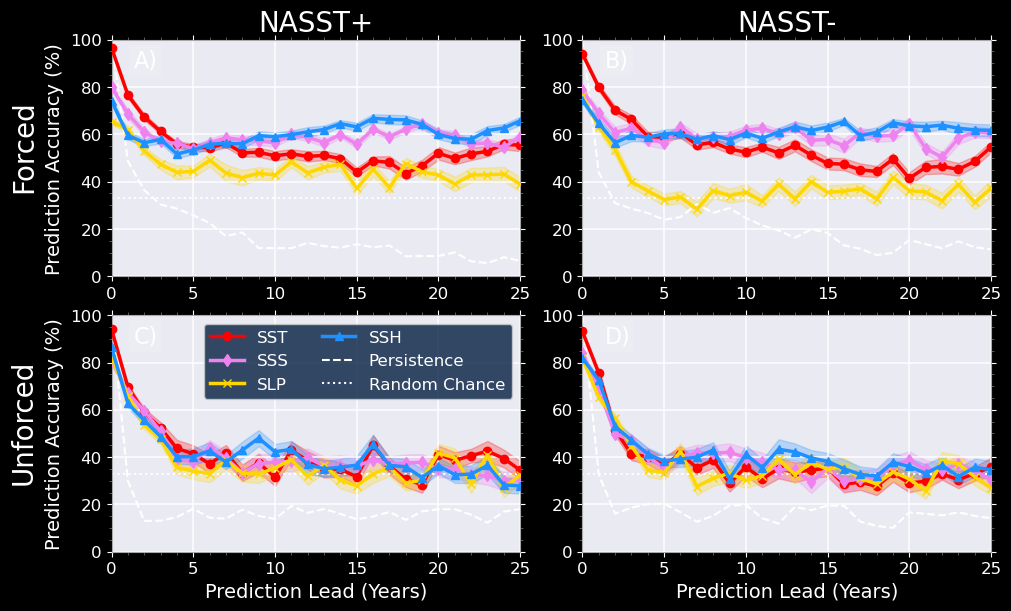

In [30]:
# Make Fig 2
# ----------------------------------

# Set Color Mode
# darkmode = False
# if darkmode == True:
#     plt.style.use('dark_background')
#     dfcol = "w"
# else:
#     plt.style.use('default')
#     dfcol = "k"

# Get some needed information variables
nvars        = len(varnames)

# Toggles and ticks
plotclasses  = [0,2]     # Just plot positive/negative
expnums      = [0,1]     # Which Experiments to Plot
detrends     = [0,1]     # Whether or not it was detrended
leadticks    = np.arange(0,26,5)
legend_sp    = 2         # Subplot where legend is included
ytks         = np.arange(0,1.2,.2)

# Error Bars
plotstderr   = True  # If True, plot standard error (95%), otherwise plot 1-stdev
alpha        = 0.25  # Alpha of error bars

# Initialize figures
fig,axs =  plt.subplots(2,2,constrained_layout=True,figsize=(10,6))
it = 0
for iplot,ex in enumerate(expnums):
    
    # Get the axes row
    axs_row = axs[iplot,:]
    
    # Unpack the data
    totalacc = np.array([alloutputs[ex][v]['total_acc'] for v in range(nvars)])
    classacc = np.array([alloutputs[ex][v]['class_acc'] for v in range(nvars)])
    ypred    = np.array([alloutputs[ex][v]['predictions'] for v in range(nvars)])
    ylabs    = np.array([alloutputs[ex][v]['targets'] for v in range(nvars)])
    
    # Indicate detrending
    exp_dt = detrends[ex]
    
    for rowid,c in enumerate(plotclasses):
        
        ax = axs_row[rowid]
        
        # Initialize plot
        viz.label_sp(it,ax=ax,fig=fig,fontsize=pparams.fsz_splbl,
                     alpha=0.1,y=.99,x=0.02,fontcolor=dfcol)
        
        # Set Ticks/limits
        ax.set_xlim([0,24])
        ax.set_xticks(leadticks,labels=leadticks,fontsize=pparams.fsz_ticks)
        ax.set_ylim([0,1])
        ax.set_yticks(ytks,)
        ax.set_yticklabels((ytks*100).astype(int),fontsize=pparams.fsz_ticks)
        ax = viz.add_ticks(ax,facecolor="#eaeaf2",grid_lw=1.5,grid_col="w",grid_ls="solid",
                            spinecolor="darkgray",tickcolor="dimgray",
                            ticklabelcolor="k",fontsize=pparams.fsz_ticks)
        
        # Add Class Labels
        if iplot == 0:
            ax.set_title("%s" %(classes_new[c]),fontsize=pparams.fsz_title,)
        
        # Loop for each predictor
        for i in range(nvars):
            
            # Compute Mean and 2*stderr (or sigma)
            mu       = classacc[i,:,:,c].mean(0)
            if plotstderr:
                sigma = 2*classacc[i,:,:,c].std(0) / np.sqrt(classacc.shape[1])
            else:
                sigma = np.array(plotacc).std(0)
            
            # Plot mean and bounds
            ax.plot(leads,mu,color=varcolors[i],marker=varmarker[i],alpha=1.0,lw=2.5,label=varnames[i],zorder=3)
            ax.fill_between(leads,mu-sigma,mu+sigma,alpha=alpha,color=varcolors[i],zorder=1)
        
        # Plot the persistence and chance baselines
        ax.plot(leads,persaccclass[exp_dt][:,c],color=dfcol,label="Persistence",ls="dashed")
        ax.axhline(chance_baseline[c],color=dfcol,label="Random Chance",ls="dotted")
        
        # Additional Labeling (y-axis and experiment)
        if c == 0:
            ax.set_ylabel("Prediction Accuracy (%)",fontsize=pparams.fsz_axlbl,) # Label Y-axis for first column
            ax.text(-0.18, 0.55,expdirs_long[ex], va='bottom', ha='center',rotation='vertical',
                    rotation_mode='anchor',transform=ax.transAxes,fontsize=pparams.fsz_title)
        
        # Label x-axis and set legend
        if (ex == 1):
            ax.set_xlabel("Prediction Lead (Years)",fontsize=pparams.fsz_axlbl,) # Label Y-axis for first column
        if it == legend_sp:
            ax.legend(ncol=2,fontsize=pparams.fsz_legend,facecolor=list(darkblue))
            
        ax.tick_params(axis='both', colors=dfcol)
        it += 1

if pubready:
    savename = "%sFigure02_Predictor_Intercomparison.pdf" % (figpath)
    print("Saving figure to %s" % figpath)
    proc.savefig_pub(savename,fig,format="pdf")
else:  
    plt.savefig("%sPredictor_Intercomparison_byclass_stderr%i_%s.png"% (figpath,plotstderr,comparename),
                dpi=300,bbox_inches="tight",transparent=True)

## 3. Figure 3: Relevance Composites for correct NASST+ predictions

Creates relevance composites for correct class predictions (NASST+,Neutral,NASST-) of the top 50 performing networks.

Inputs
 - Relevance and predictor composites computed from \[compute_test_metrics.py\], located in "[datpath]/[expdir]/Metrics/Test_Metrics/"
 
Contents
1. User Edits
2. Load in Computed Relevances + Predictors Composites
3. Composite Top N Performing Networks
4. Make Figure

Notes
 - Look for <!!> for areas to make key changes related to creating the manuscript figures.
 - To Make Figure 4 (LRP Maps for NASST+, forced), change "expdir" to "FNN_128_SingleVar_PaperRun" and c = 0.
 - To make Figure S5 (LRP Maps for NASST-), change c = 2.
 - To make Figure S6 (LRP Maps for NASST+, unforced), change "expdir" to "FNN_128_SingleVar_PaperRun_detrended" and c = 0.

*Moved from working script \[viz_LRP_predictor.py\] on 2023.09.13*

In [46]:
# Figure 3: User Edits
# --------------------------

# <!!> Change Expdir
expdir         = "FNN4_128_SingleVar_PaperRun_detrended" # Change expdir here!!
# For c, check below in plotting cell...

# Data and variable settings
varnames       = ("SST","SSH","SSS","SLP") 
varnames_plot  = ("SST","SSH","SSS","SLP")
eparams        = train_cesm_params.train_params_all[expdir]
classes        = classes_new
datpath        = "../../results_manuscript/"
metrics_dir    = "%s%s/Metrics/Test_Metrics/" % (datpath,expdir)
print(metrics_dir)

# Compositing options
nmodels        = 100 # Specify manually how many networks to load for the analysis
topN           = 50 # Top N networks to include in composite

# Plotting Options
proj           = ccrs.PlateCarree()

# Toggles
debug          = False

../../results_manuscript/FNN4_128_SingleVar_PaperRun_detrended/Metrics/Test_Metrics/


In [47]:
# Load the Relevance and Predictor Composites
# -----------------------------
nvars       = len(varnames)
nleads      = len(leads)
#metrics_dir = "%s%s/Metrics/Test_Metrics/" % (datpath,expdir)
pcomps   = []
rcomps   = []
ds_all   = []
acc_dict = []
for v in range(nvars):
    # Load the composites
    varname = varnames[v]
    ncname = "%sTest_Metrics_CESM1_%s_evensample0_relevance_maps.nc" % (metrics_dir,varname)
    ds     = xr.open_dataset(ncname)
    rcomps.append(ds['relevance_composites'].values)
    pcomps.append(ds['predictor_composites'].values)
    
    # Load the accuracies
    ldname  = "%sTest_Metrics_CESM1_%s_evensample0_accuracy_predictions.npz" % (metrics_dir,varname)
    npz     = np.load(ldname,allow_pickle=True)
    expdict = proc.npz_to_dict(npz)
    acc_dict.append(expdict)

nleads,nruns,nclasses,nlat,nlon=rcomps[v].shape
lon = ds.lon.values
lat = ds.lat.values

In [37]:
# Composite top N performing networks for each class
# --------------------------------------------------
class_accs  = [acc_dict[v]['class_acc'] for v in range(nvars)]
rcomps_topN = np.zeros((nvars,nleads,nclasses,nlat,nlon))
pcomps_topN = np.zeros((nvars,nleads,nclasses,nlat,nlon))

for v in range(nvars):
    for l in tqdm.tqdm(range(nleads)):
        for c in range(nclasses):
            # Get ranking of models by test accuracy
            acc_list = class_accs[v][:,l,c] # [runs]
            id_hi2lo  = np.argsort(acc_list)[::-1] # Reverse to get largest value first
            id_topN   = id_hi2lo[:topN]
            
            # Make relevance composites
            rcomp_in  = rcomps[v][l,id_topN,c,:,:] # [runs x lat x lon]
            rcomps_topN[v,l,c,:,:] = rcomp_in.mean(0) # Mean along run dimension
            
            # Make predictor composite
            if len(pcomps[v].shape) == 5:
                pcomp_in  = pcomps[v][l,id_topN,c,:,:].mean(0)
            else:
                #print("Composites are not different by network")
                pcomp_in  = pcomps[v][l,c,:,:]
            pcomps_topN[v,l,c,:,:] = pcomp_in

100%|███████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 808.03it/s]


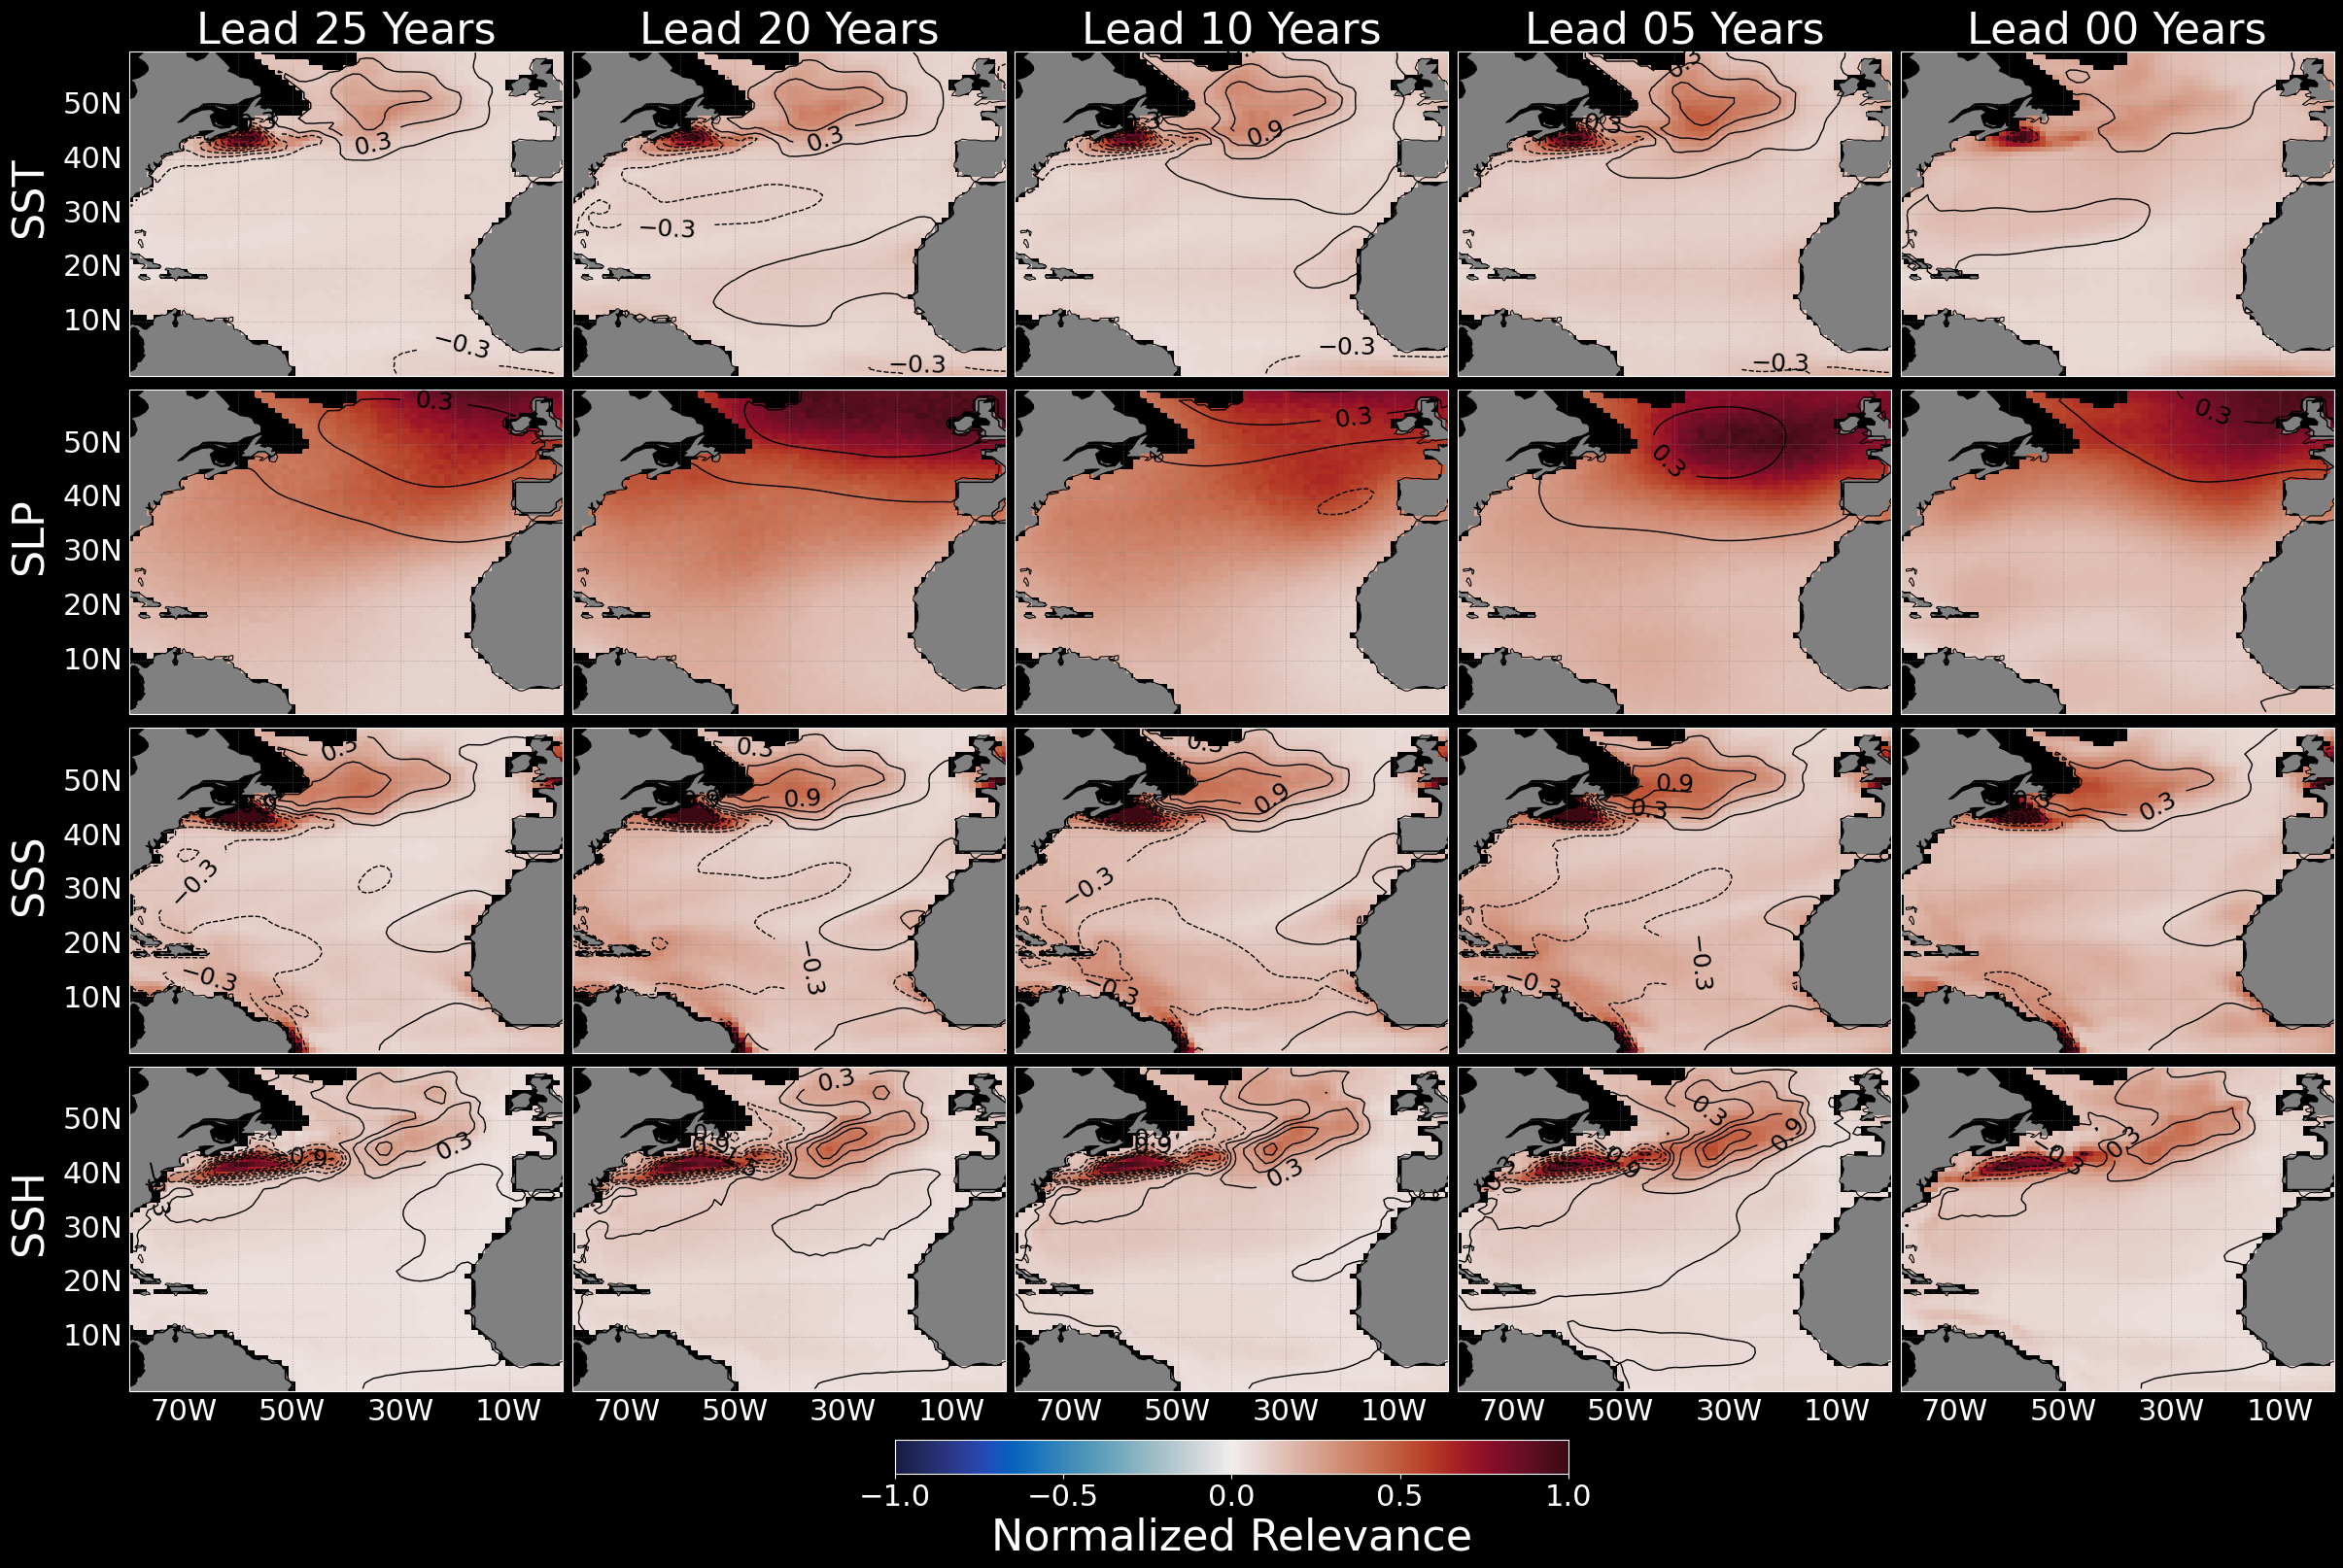

In [43]:
# Make Fig. 3
# -----------
pubready=False

# <!!> Select which class you would like to plot 
c               = 1 # Class Index, where 0=NASST+, 1=Neutral, 2=NASST-

# Set darkmode
transparent = True
darkmode    = True
# if darkmode:
#     plt.style.use('dark_background')
#     dfcol = "w"
#     transparent      = True
# else:
#     plt.style.use('default')
#     dfcol = "k"
#     transparent      = False

# Indicate which variables to plot
plotvars         = pparams.varnames[:4]
plotorder        = [0,3,2,1] # Indices based on pparams.varnames

# Select which leadtimes to plot, as well as the bounding box
plot_bbox        = [-80,0,0,60]
leadsplot        = [25,20,10,5,0]

# Additional Options
normalize_sample = 2 # 0=None, 1=samplewise, 2=after composite
absval           = False
cmax             = 1
cmin             = 1
clvl             = np.arange(-2.1,2.1,0.3)
no_sp_label      = True
cmap             ='cmo.balance'

# Font Sizes
fsz_title        = 32
fsz_axlbl        = 32
fsz_ticks        = 22
fsz_contourlbl   = 18

ia = 0
fig,axs = plt.subplots(4,5,figsize=(24,16),
                       subplot_kw={'projection':proj},constrained_layout=True)
# Loop for variable
for v,varname in enumerate(plotvars):

    iv = plotorder[v]
    # Loop for leadtime
    for l,lead in enumerate(leadsplot):

        # Get lead index
        id_lead    = list(leads).index(lead)

        if debug:
            print("Lead %02i, idx=%i" % (lead,id_lead))

        # Axis Formatting
        ax = axs[v,l]
        blabel = [0,0,0,0]

        if v == 0:
            ax.set_title("Lead %02i Years" % (leads[id_lead]),fontsize=fsz_title)
        if l == 0:
            blabel[0] = 1
            ax.text(-0.18, 0.55, varnames_plot[iv], va='bottom', ha='center',rotation='vertical',
                    rotation_mode='anchor',transform=ax.transAxes,fontsize=fsz_title)
        if v == (len(plotvars)-1):
            blabel[-1]=1

        ax = viz.add_coast_grid(ax,bbox=plot_bbox,blabels=blabel,fill_color='gray',fontsize=fsz_ticks,ignore_error=True)
        if no_sp_label is False:
            ax = viz.label_sp(ia,ax=ax,fig=fig,alpha=0.8,fontsize=fsz_axlbl)


        # --------- Composite the Relevances and variables --------
        plotrel = rcomps_topN[iv,id_lead,c,:,:]
        if normalize_sample == 2:
            plotrel = plotrel/np.max(np.abs(plotrel))
        plotvar = pcomps_topN[iv,id_lead,c,:,:]

        # Boost SSS values by 1.5
        if varnames_plot[iv] == "SSS":
            plotrel = plotrel*2
        #plotvar = plotvar/np.max(np.abs(plotvar))

        # Set Land Points to Zero
        plotrel[plotrel==0] = np.nan
        plotvar[plotrel==0] = np.nan

        # Do the plotting
        pcm=ax.pcolormesh(lon,lat,plotrel,vmin=-cmin,vmax=cmax,cmap=cmap)
        cl = ax.contour(lon,lat,plotvar,levels=clvl,colors="k",linewidths=1)
        ax.clabel(cl,clvl[::2],fontsize=fsz_contourlbl)
        ia += 1

        # Finish Leadtime Loop (Column)
    # Finish Variable Loop (Row)

# Make Colorbar
cb = fig.colorbar(pcm,ax=axs.flatten(),orientation='horizontal',fraction=0.025,pad=0.01)
cb.set_label("Normalized Relevance",fontsize=fsz_axlbl)
cb.ax.tick_params(labelsize=fsz_ticks)

# Make overall title
if not no_sp_label:
    plt.suptitle("Mean LRP Maps for Predicting %s, \n Composite of Top %02i FNNs per leadtime" % (classes[c],topN,),
                fontsize=fsz_title)

# Save Figure
if pubready:
    if (expdir == "FNN4_128_SingleVar_PaperRun") and (c == 0):
        print("Making Figure 3")
        savename = "%sFigure03_LRP_AMVpos_CESM1.pdf" % figpath
        
    elif (expdir == "FNN4_128_SingleVar_PaperRun") and (c == 2):
        print("Making Figure S5")
        savename = "%sFigureS5_LRP_AMVneg_CESM1.pdf" % figpath
        
    elif (expdir == "FNN4_128_SingleVar_PaperRun_detrended") and (c == 0):
        print("Making Figure S6")
        savename = "%sFigureS6_LRP_AMVpos_detrend.pdf" % figpath
        
    else:
        print("Warning: Experiment and Class Composite Combination not included in Publication.")
        savename = "%sPredictorComparison_LRP_%s_%s_top%02i_normalize%i_abs%i.pdf" % (figpath,expdir,classes[c],topN,normalize_sample,absval)
    
    proc.savefig_pub(savename,fig,format='pdf')
    savename = savename.replace('pdf','png')
    proc.savefig_pub(savename,fig,format='png',dpi=400)
else:
    
    savename = "%sPredictorComparison_LRP_%s_%s_top%02i_normalize%i_abs%i.png" % (figpath,expdir,classes[c],topN,normalize_sample,absval)
    if darkmode:
        savename = proc.addstrtoext(savename,"_darkmode")
    if transparent:
        facecolor="None"
    else:
        facecolor=darkblue
    plt.savefig(savename,dpi=150,bbox_inches="tight",transparent=transparent,facecolor=facecolor)


In [163]:
savename

'../../results_presentation/FigureS5_LRP_AMVneg_CESM1.png'

## 4. Figure 4: Class Prediction Count by Year for HadISST

Frequency of each class prediction by year for the forced HadISST NASST Index, using NNs trained with forced CESM1 SST.

Inputs:
 - Predictions computed in \[test_observations.py\], located in "[datpath]/[expdir]/Metrics/Test_Metrics/"
 - Target from HadISST computed in \[regrid_reanalysis_cesm1.py\], located in "[datpath]/Reanalysis/Regridded/"
 
Contents:
1. User Edits
2. Load in HadISST NASST Index (Target)
3. Load in testing results
4. Bin predictions by year
5. Visualize

Notes:
 - Generates Figure 4 if expdir  == "FNN4_128_SingleVar_PaperRun"
 - Generates Figure S7 if expdir == "FNN4_128_SingleVar_PaperRun_detrended"

*Moved from working script \[viz_LRP_predictor.py\] on 2023.09.13*

In [48]:
# User Edits
# ----------

# HadISST Information
datpath_hadisst    = "%s/Reanalysis/regridded/" % datpath # Path to Target

if "detrend" in expdir:
    detrend            = True
else:
    detrend            = False
dataset_name       = "HadISST"
region_name        = "NAT"
varname            = "SST"

# Set Manual NASST Threshold for classification
manual_threshold   = None # Set to None to automatically detect


In [49]:
# Load in HadISST NASST Index (Target)
# ------------------------------------
re_target  = dl.load_target_reanalysis(dataset_name,region_name,detrend=detrend,datpath=datpath_hadisst)
re_target  = re_target[None,:] # ens x year
nens,ntime = re_target.shape

In [50]:
# Load testing results
# --------------------
savename  = "%s%s/Metrics/Test_Metrics/Test_Metrics_HadISST_%s_accuracy_predictions.npz" % (datpath,expdir,varname)
ld        = np.load(savename,allow_pickle=True)
print(ld.files)

y_predicted_all          = ld['predictions'] 
nleads,nruns,ntime_final = y_predicted_all.shape # [Lead, Run, Year]
class_acc                = ld['class_acc'] # [Lead, Run, Class]

['total_acc', 'class_acc', 'predictions', 'targets', 'leads', 'runids', 'allow_pickle']


In [51]:
# Bin predictions by year
# -----------------------
selected_leads      = leads.copy() #[0,6,12,18,24]
nleads_sel          = len(selected_leads)
count_by_year_leads = np.zeros((ntime_final,nclasses,nleads_sel))

for y in range(ntime_final):
    for ll in range(nleads_sel):
        sel_lead_index = list(leads).index(selected_leads[ll])
        y_pred_year    = y_predicted_all[sel_lead_index,:,y]
        for c in range(3):
            count_by_year_leads[y,c,ll] = (y_pred_year == c).sum()

%s) A) Interannual (1-9 years), Mean Accuracy: 51.66%
%s) B) Decadal (10-19 years), Mean Accuracy: 34.30%
%s) C) Multidecadal (20-26 years), Mean Accuracy: 36.08%


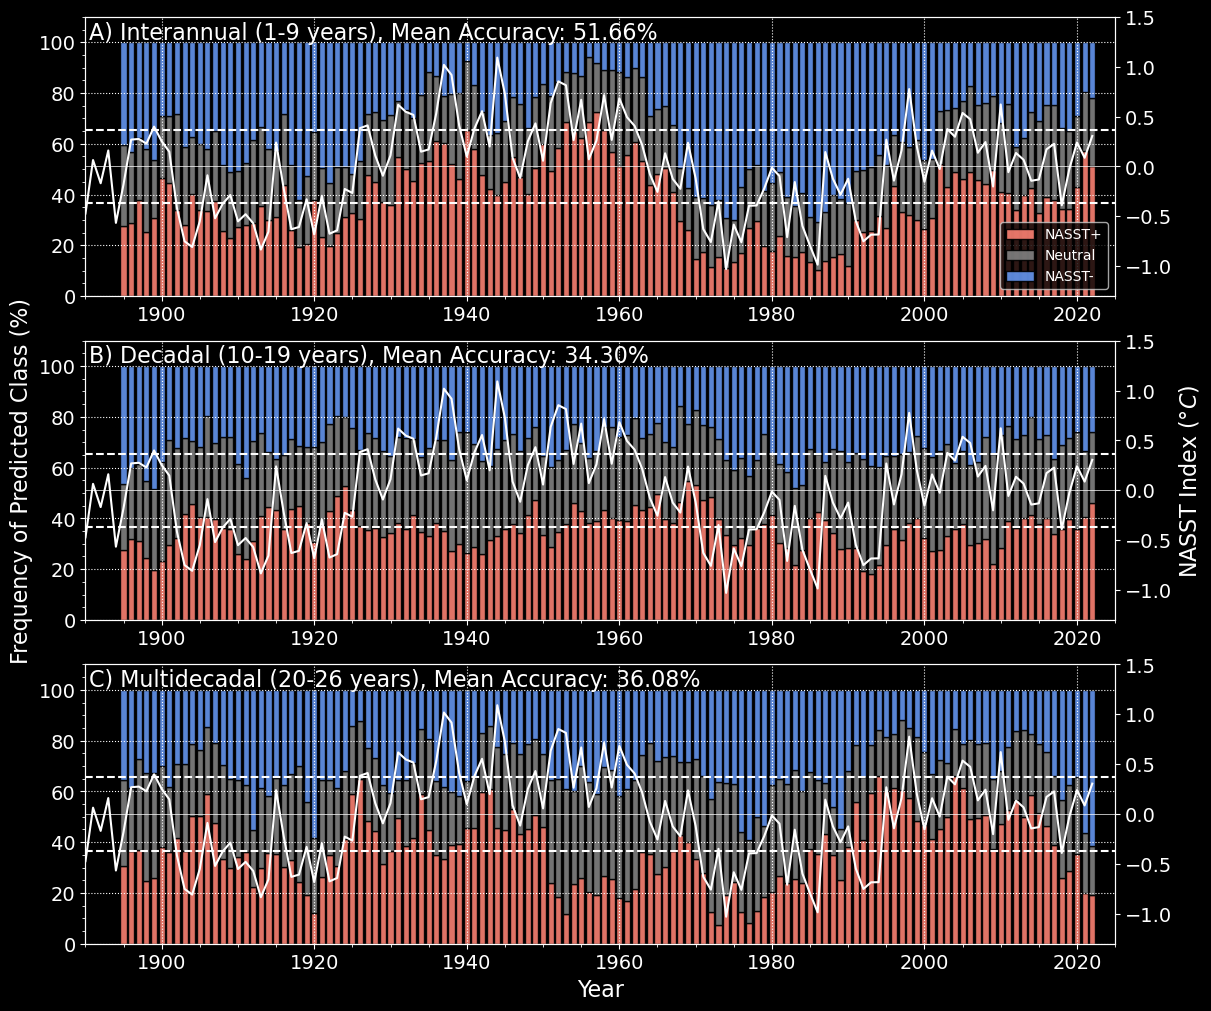

In [53]:
# Make Fig. 4
# -------------

transparent = True
if transparent:
    facecolor="None"
else:
    facecolor=darkblue

# count_by_year_leads # [year x class x lead]
interann_count      = count_by_year_leads[:,:,np.arange(1,10)].sum(2) # year x class
decadal_count       = count_by_year_leads[:,:,np.arange(10,20)].sum(2)
multidecadal_count  = count_by_year_leads[:,:,np.arange(20,26)].sum(2)

# Get the accuracies
lbl_acc     = True
include_std = False
stderr      = False
included_classes  = [0,2] # Classes to include in accuracy
if lbl_acc:
    class_acc_in      = class_acc[:,:,included_classes]
    interann_acc      = np.nanmean(class_acc_in[np.arange(1,10),:,:],(0,1,2)) # Class
    decadal_acc       = np.nanmean(class_acc_in[np.arange(10,20),:,:],(0,1,2)) # Class
    multidecadal_acc  = np.nanmean(class_acc_in[np.arange(20,26),:,:],(0,1,2)) # Class
    
    interann_std          = np.nanstd(class_acc_in[np.arange(1,10),:,:],(0,1,2)) # Class
    decadal_std           = np.nanstd(class_acc_in[np.arange(10,20),:,:],(0,1,2)) # Class
    multidecadal_std      = np.nanstd(class_acc_in[np.arange(20,26),:,:],(0,1,2)) # Class
    
    avg_accs_timescale    = [interann_acc,decadal_acc,multidecadal_acc]
    std_accs_timescale    = [interann_std,decadal_std,multidecadal_std]
    
    # Standard Error
    if stderr:
        n = np.array([len(np.arange(1,10)),len(np.arange(10,20)),len(np.arange(20,26))]) * class_acc.shape[1] * len(included_classes)
        
        print(n)
        std_accs_timescale = [std_accs_timescale[jj] * 2 / np.sqrt(n[jj]) for jj in range(3)]

ABC                 = ["A","B","C"]
counts_in           = [interann_count,decadal_count,multidecadal_count]
count_labels        = ["Interannual (1-9 years)","Decadal (10-19 years)", "Multidecadal (20-26 years)"]
class_colors        = pparams.class_colors

# Plot Settings
leadmax             = 25
fsz_axlbl           = 16
fsz_ticks           = 14

fig,axs = plt.subplots(3,1,constrained_layout=True,figsize=(12,10))
for ii in range(3):
    ax = axs[ii]

    # Set up timeaxis
    timeaxis      = np.arange(0,len(re_target.squeeze()))
    timeaxis_in   = np.arange(leadmax,re_target.shape[1])
    
    # Plot the counts
    plotcount = counts_in[ii]
    maxcount  = plotcount.sum(-1)
    for c in range(3):
        label = classes[c]
        plotcount = plotcount
        ax.bar(timeaxis_in+1870,plotcount[:,c]/maxcount*100,bottom=plotcount[:,:c].sum(1)/maxcount*100,
               label=label,color=class_colors[c],alpha=0.9,edgecolor=dfcol_r,linewidth=1)
    
    # Label and set ticks
    if ii == 0:
        ax.legend(loc='lower right')
    if ii == 1:
        ax.set_ylabel("Frequency of Predicted Class (%)",fontsize=fsz_axlbl)
    ax.minorticks_on()
    ax.grid(True,ls="dotted")
    ax.set_xlim([1890,2025])
    ax.set_ylim([0,110])
    if ii == 2:
        ax.set_xlabel("Year",fontsize=fsz_axlbl)
    
    # Plot NASST Index on Separate Axis
    ax2 = ax.twinx()
    ax2.plot(timeaxis+1870,re_target.squeeze(),color=dfcol,label="HadISST NASST Index")
    if ii == 1:
        ax2.set_ylabel("NASST Index ($\degree C$)",fontsize=fsz_axlbl)
    ax2.set_ylim([-1.3,1.5])
    for th in thresholds_in:
        ax2.axhline([th],color=dfcol,ls="dashed")
    ax2.axhline([0],color=dfcol,ls="solid",lw=0.5)
    
    if lbl_acc:
        if include_std:
            lbl_sp = "%s) %s, Mean Accuracy: %.2f $\pm$ %.2f" % (ABC[ii],count_labels[ii],avg_accs_timescale[ii]*100,std_accs_timescale[ii]*100) + "%"
        else:
            lbl_sp = "%s) %s, Mean Accuracy: %.2f" % (ABC[ii],count_labels[ii],avg_accs_timescale[ii]*100) + "%"
    else:
        lbl_sp = "%s) %s" % (ABC[ii],count_labels[ii])
    print("%s) " + lbl_sp)
    ax = viz.label_sp(lbl_sp,ax=ax,fig=fig,alpha=0,fontsize=fsz_axlbl,usenumber=True,fontcolor=dfcol,labelstyle="%s",y=1.010,x=-0.01)#labelstyle="%s) " + lbl_sp)# " + lbl_sp)
    
    # Final adjustment of font sizes
    ax.tick_params(labelsize=fsz_ticks)
    ax2.tick_params(labelsize=fsz_ticks)

if pubready:
    if expdir == "FNN4_128_SingleVar_PaperRun_detrended":
        print("Saving Figure S7!")
        savename = "%sFigureS7_HadISST_Histogram_detrended.pdf" % figpath
        
    elif expdir == "FNN4_128_SingleVar_PaperRun":
        print("Saving Figure 4!")
        savename = "%sFigure04_HadISST_Histogram.pdf" % figpath
        
    else:
        print("Warning: Figure not in publication.")
        savename = "%sHadISST_Prediction_Count_Lead_TimeSplit_%s.pdf"% (figpath,expdir)
    proc.savefig_pub(savename,fig,format='pdf')
else:
    if figpath is not None:
        figname = "%sHadISST_Prediction_Count_Lead_TimeSplit_%s.png"% (figpath,expdir)
        plt.savefig(figname,dpi=150,bbox_inches="tight",transparent=transparent,facecolor=facecolor)

## 5. Figure S1: Hyperparameter Testing for FNNs

Visualize how change the number of layers and units impacts prediction accuracy for networks trained with SSH.

Inputs:
 - Works with output from "train_gridsearch.py"
 

Contents:
1. User Edits, Declare Variables
2. Load FNN Metrics
3. Visualize Accuracy

*Copied from \[analyze_gridsearch_output.py\] on 2023.20.11*


In [123]:
#  -------------------------
# 1.  User Edits, Declare Variables
#  -------------------------

# Set experiment directory/key used to retrieve params from [train_cesm_params.py]
expdir              = "FNN4_128_SingleVar_PaperRun"
eparams             = train_cesm_params.train_params_all[expdir] # Load experiment parameters

# Set some looping parameters and toggles
varnames            = ['SSH',]# Only Supportss 1!! ["SST","SSS","SLP","NHFLX",]       # Names of predictor variables
leads               = np.arange(0,26,1)    # Prediction Leadtimes
runids              = np.arange(0,50,1)    # Which runs to do

# Save looping parameters into parameter dictionary
eparams['varnames'] = varnames
eparams['leads']    = leads
eparams['runids']   = runids

splabels_class = ['A) NASST+','B) Neutral','C) NASST-']
splabels_class2 = ['A) NASST+','B) NASST-']

# Set some variables needed
varname    = varnames[0]

# For FNN4, test the number of layers and units
nlayers  = [2,4,6,8,10]      # Number of Layers
nunits   = [64,128,256]      # Number of Units

# Set up testing dictionary
test_param_names  = ["nlayers","nunits",]
test_param_values = [nlayers,nunits]
test_params       = dict(zip(test_param_names,test_param_values))

# Get some measurements
nparams = len(test_param_names)
nvalues = [len(p) for p in test_param_values]
ntotal  = np.prod(nvalues)

# Make Parameter combinations -------------------------------------------------
param_combinations = list(itertools.product(*test_param_values))
ncombos            = len(param_combinations)
#print(ntotal       == len(param_combinations))

#%% Load base experiment dictionary -------------------------------------------
nnparams_original = pparams.nn_param_dict[eparams['netname']].copy()
eparams_original  = eparams.copy()


In [124]:
#  -------------------------
# 2. Load the FNN Metrics
# --------------------------

combo_names = []

nruns = len(runids)
nleads = len(leads)
nclasses = len(pparams.classes)
accs_all = np.full((ncombos,nruns,nleads,nclasses),np.nan)

for nc in range(ncombos): # Loop for each combination -------------------------
    pcomb           = param_combinations[nc]
    ct              = time.time()
    
    # Copy dictionaries to use for this particular combo
    combo_expdict   = eparams_original.copy()
    combo_paramdict = nnparams_original.copy()

    # Get the Experiment string and replace into the dictionaray
    expstr = ""
    for p in range(nparams):
        
        # Make the experiment string
        name = test_param_names[p]
        expstr += "%s%s_" % (name,pcomb[p])
        
        # Copy parameters into dictionary ----------------------------
        if name in combo_expdict.keys(): # Check experiment dictionary
            print("Found <%s> in eparams_original;\t replacing with value: %s" % (name,pcomb[p]))
            combo_expdict[name] = pcomb[p]
        elif name in combo_paramdict.keys(): # Check parameter dictionary
            print("Found <%s> in nnparams_original;\t replacing with value: %s" % (name,pcomb[p]))
            combo_paramdict[name] = pcomb[p]
        # ------------------------------------------------------------
    
    # Make the experiment string and prepare the folder
    expstr = expstr[:-1]
    print(expstr)
    outdir = "%s%s/ParamTesting/%s/Metrics/" % (datpath,expdir,expstr)
    combo_names.append(expstr)
    
    # Retrieve the metrics file
    flist = glob.glob("%s*%s*ALL.npz" % (outdir,varname))
    nruns = len(flist)
    flist.sort()
    print("Found %i files" % (nruns))
    
    # Read the files
    
    for f in range(nruns):
        ld  = np.load(flist[f])
        acc = ld['acc_by_class']
        accs_all[nc,f,:,:] = acc.copy()

Found <nlayers> in nnparams_original;	 replacing with value: 2
Found <nunits> in nnparams_original;	 replacing with value: 64
nlayers2_nunits64
Found 50 files
Found <nlayers> in nnparams_original;	 replacing with value: 2
Found <nunits> in nnparams_original;	 replacing with value: 128
nlayers2_nunits128
Found 50 files
Found <nlayers> in nnparams_original;	 replacing with value: 2
Found <nunits> in nnparams_original;	 replacing with value: 256
nlayers2_nunits256
Found 50 files
Found <nlayers> in nnparams_original;	 replacing with value: 4
Found <nunits> in nnparams_original;	 replacing with value: 64
nlayers4_nunits64
Found 50 files
Found <nlayers> in nnparams_original;	 replacing with value: 4
Found <nunits> in nnparams_original;	 replacing with value: 128
nlayers4_nunits128
Found 50 files
Found <nlayers> in nnparams_original;	 replacing with value: 4
Found <nunits> in nnparams_original;	 replacing with value: 256
nlayers4_nunits256
Found 50 files
Found <nlayers> in nnparams_original;	

Saving Figure S1!


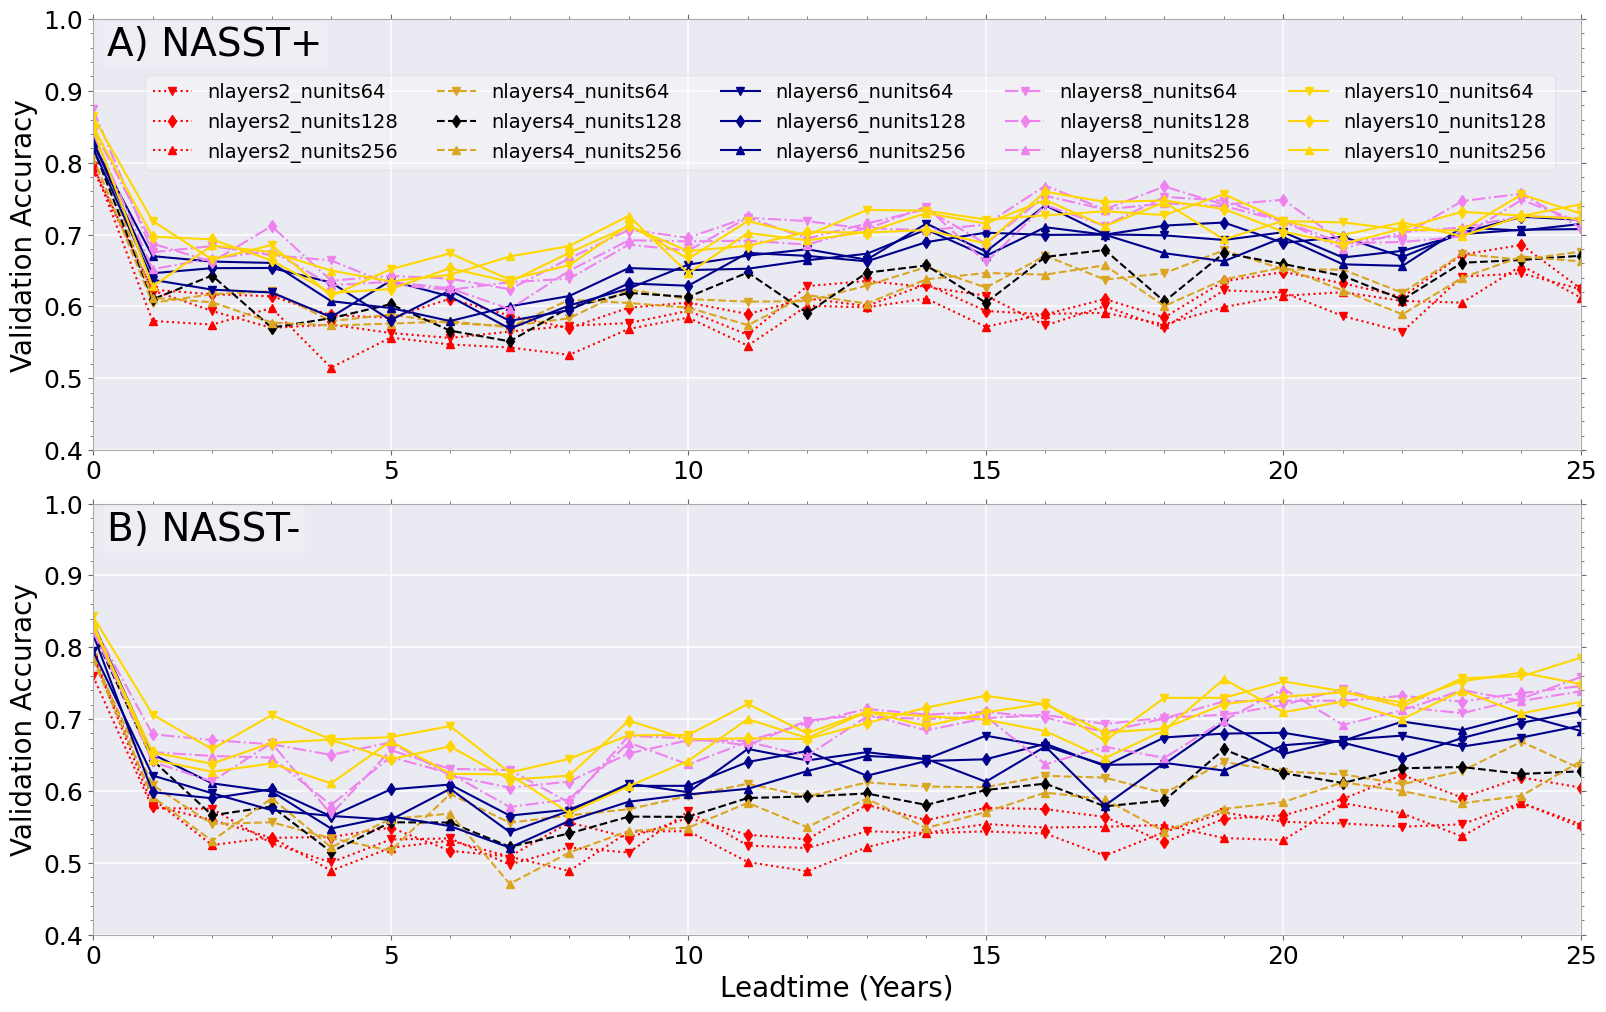

In [125]:
# --------------------------
# Fig. S1 : FNN4 Hyperparams, but just NASST+ and NASST- (Figure S1, Revision 01)
# --------------------------

class_choose  = [0,2] # Plot NASST+ and NASST-
idori_nodrop  = param_combinations.index((4, 128)) # Get indices for selected network architecture
idori         = [idori_nodrop]

# Set Font Sizes and Ticks
fsz_axlbl    = 20
fsz_splbl    = 28
fsz_tklbl    = 18
leadticks    = np.arange(0,26,5)

# Initialize Figure and Plot
fig,axs = plt.subplots(2,1,constrained_layout=True,figsize=(16.5,10))

for a in range(2):
    iclass = class_choose[a]
    ax = axs[a]
    if iclass in [0,2]:
        xlm = [0.4,1]
    else:
        xlm = [0,1]
    
    ax = viz.add_ticks(ax,facecolor="#eaeaf2",grid_lw=1.5,grid_col="w",grid_ls="solid",
                    spinecolor="darkgray",tickcolor="dimgray",
                    ticklabelcolor="k",fontsize=fsz_tklbl)
    
    viz.label_sp(splabels_class2[a],labelstyle="%s",usenumber=True,
                 ax=ax,fig=fig,fontsize=fsz_splbl,
             alpha=0.2,x=0.)
    
    for nc in range(ncombos):
        
        pcomb = param_combinations[nc]
        
        if pcomb[-1] == True:
            continue
        
        if pcomb[0] == 2:
            ls = 'dotted'
            c  = "red"
        elif pcomb[0] == 4:
            ls = 'dashed'
            c  = "goldenrod"
        elif pcomb[0] == 6:
            ls = 'solid'
            c  = "darkblue"
        elif pcomb[0] == 8:
            ls = 'dashdot'
            c  = 'violet'
        elif pcomb[0] == 10:
            ls = 'solid'
            c  = "gold"
        
        if pcomb[1] == 64:
            #alpha = 0.2
            marker = "v"
        elif pcomb[1] == 128:
            #alpha = 0.6
            marker = 'd'
        elif pcomb[1] == 256:
            #alpha = 1
            marker = '^'
        alpha = 1
        plot_acc = accs_all[nc,:,:,iclass].mean(0)
        lbl = combo_names[nc].replace("_dropoutFalse","")
        if nc in idori:
            
            ax.plot(leads,plot_acc,label=lbl,ls=ls,color="k",alpha=alpha,marker=marker)
        else:
            ax.plot(leads,plot_acc,label=lbl,ls=ls,alpha=alpha,marker=marker,color=c)

    ax.set_ylim([xlm[0],xlm[-1]])
    ax.set_xlim([0,25])

    ax.set_ylabel("Validation Accuracy",fontsize=fsz_axlbl)
    if a == 0:
        ax.legend(ncol=5,fontsize=14,loc=[.035,.65],framealpha=0.3)
    elif a == 1:
        ax.set_xlabel("Leadtime (Years)",fontsize=fsz_axlbl)

# Save Figure
if pubready:
    print("Saving Figure S1!")
    savename = "%sFigureS1_FNN_Hyperparameter_Testing.pdf" % (figpath)
    proc.savefig_pub(savename,fig,format='pdf')
else:
    savename = "%sFNN4_ParamTesting_%s_classALL.png" % (figpath,varname)
    plt.savefig(savename,dpi=150,bbox_inches='tight')

## 6. Figure S2: FNN4 vs. FNN6

Inputs:
 - Metrics from "compute_test_metrics.py"

Contents:
1. User Edits
2. Load in data 
3. Visualize


*Copied from \[compare_exp\] on 2023.20.11*


In [135]:
# (1) User Edits

# FNN 4 vs FNN 6
expdirs         = ("FNN4_128_Singlevar_PaperRun","FNN6_128_PaperRun")
expdirs_long    = ("FNN4","FNN6")
comparename     = "FNN4_v_FNN6"

# Other Settings
chance_baseline = (0.33,)*3

# Variables and other settings
varnames        = ('SST', 'SSS', 'SLP', 'SSH')
varcolors       = ("r","violet","gold","dodgerblue",)
varmarker       = ("o","d","x","^")
classes_new     = ("NASST+","Neutral","NASST-")
leads           = np.arange(0,26,1)

In [136]:
# (2) Load Results


# Load the FNN Accuracy By Predictor
# ----------------------------------
alloutputs = []
for expdir in expdirs:
    output_byvar = []
    for v in varnames:
        fn              = "%s%s/Metrics/Test_Metrics/Test_Metrics_CESM1_%s_evensample0_accuracy_predictions.npz" % (datpath,expdir,v)
        npz             = np.load(fn,allow_pickle=True)
        expdict         = proc.npz_to_dict(npz)
        output_byvar.append(expdict)
    alloutputs.append(output_byvar)

# Load the Persistence Baseline
# ----------------------------------
persaccclass = []
persacctotal = []
persleads   = []
for detrend in [False,True]:
    fn_baseline      = "%s/Baselines/persistence_baseline_CESM1_NAT_detrend%i_quantile0_nsamplesNone_repeat1.npz" % (datpath,detrend,)
    ldp              = np.load(fn_baseline)
    pers_class_acc   = ldp['acc_by_class']
    pers_total_acc   = ldp['total_acc']
    pers_leads       = ldp['leads']
    persaccclass.append(pers_class_acc)
    persacctotal.append(pers_total_acc)
    persleads.append(pers_leads)

Saving Figure S2!


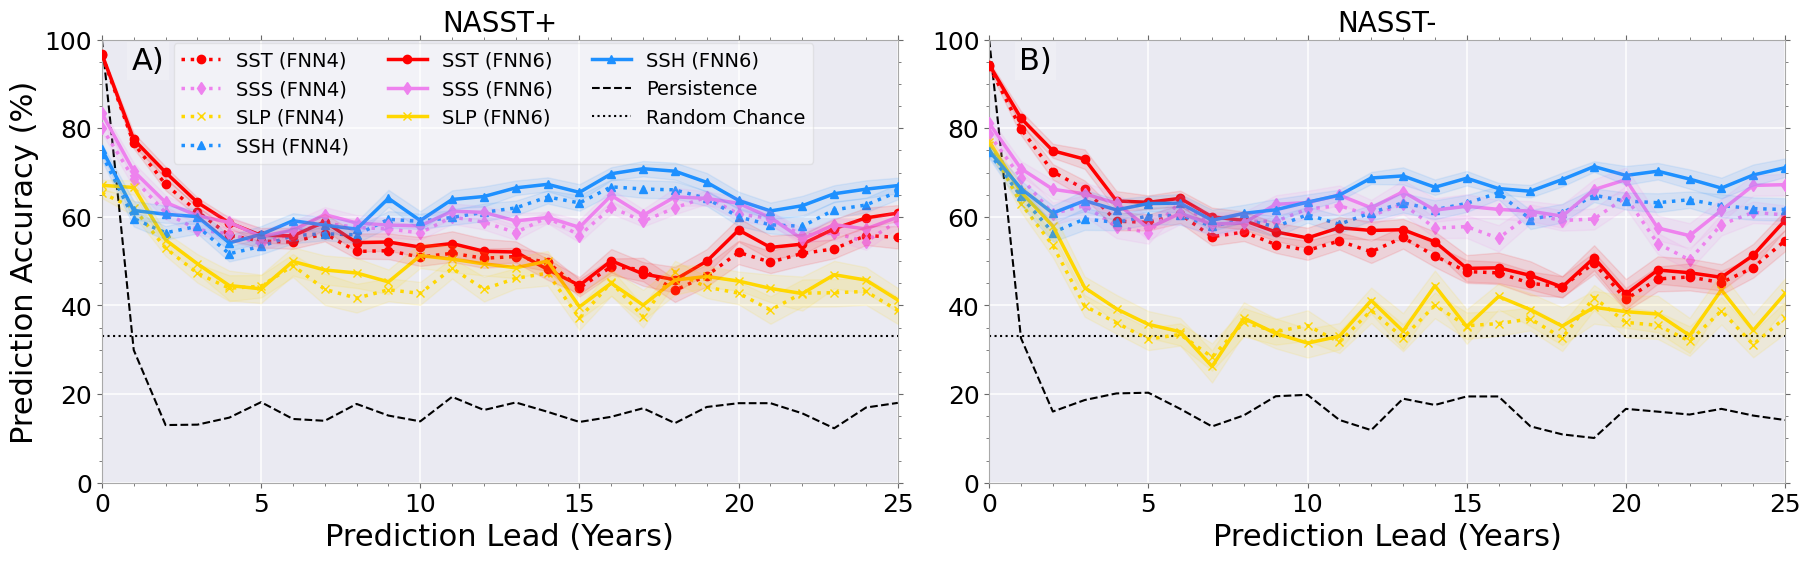

In [137]:
# (3) Visualize

# Get some needed information variables
nvars        = len(varnames)
exp_dt       = 0 # Detrend option
fsz_ticks    = 18
fsz_axlbl    = 22
fsz_legend   = 14

# Toggles and ticks
plotclasses  = [0,2]     # Just plot positive/negative
expnums      = [0,1]     # Which Experiments to Plot
detrends     = [0,1]     # Whether or not it was detrended
leadticks    = np.arange(0,26,5)
legend_sp    = 2         # Subplot where legend is included
ytks         = np.arange(0,1.2,.2)

# Error Bars
plotstderr   = True  # If True, plot standard error (95%), otherwise plot 1-stdev
alpha        = 0.1  # Alpha of error bars

# Initialize figures
fig,axs =  plt.subplots(1,2,constrained_layout=True,figsize=(18,5.5))
it = 0
for iplot,ex in enumerate(expnums):
    
    # Get the axes row
    #axs_row = axs[iplot,:]
    if iplot == 0:
        ls='dotted'
    elif iplot == 1:
        ls='solid'
    
    # Unpack the data
    totalacc = np.array([alloutputs[ex][v]['total_acc'] for v in range(nvars)])
    classacc = np.array([alloutputs[ex][v]['class_acc'] for v in range(nvars)])
    ypred    = np.array([alloutputs[ex][v]['predictions'] for v in range(nvars)])
    ylabs    = np.array([alloutputs[ex][v]['targets'] for v in range(nvars)])
    plotleads    = np.array(alloutputs[ex][0]['leads'])
    
    # Indicate detrending
    exp_dt = detrends[ex]
    
    for rowid,c in enumerate(plotclasses):
        
        ax = axs[rowid]
        
        # Initialize plot
        if ex == 0:
            viz.label_sp(it,ax=ax,fig=fig,fontsize=fsz_axlbl,
                         alpha=0.2,x=0.02)
        
        # Set Ticks/limits
        ax.set_xlim([0,24])
        ax.set_xticks(leadticks,fontsize=pparams.fsz_ticks)
        ax.set_ylim([0,1])
        ax.set_yticks(ytks,fontsize=pparams.fsz_ticks)
        ax.set_yticklabels((ytks*100).astype(int),)
        ax = viz.add_ticks(ax,facecolor="#eaeaf2",grid_lw=1.5,grid_col="w",grid_ls="solid",
                            spinecolor="darkgray",tickcolor="dimgray",
                            ticklabelcolor="k",fontsize=fsz_ticks)
        
        # Add Class Labels
        if iplot == 0:
            ax.set_title("%s" %(classes_new[c]),fontsize=pparams.fsz_title,)
        
        # Loop for each predictor
        for i in range(nvars):
            
            # Compute Mean and 2*stderr (or sigma)
            mu       = classacc[i,:,:,c].mean(0)
            if plotstderr:
                sigma = 2*classacc[i,:,:,c].std(0) / np.sqrt(classacc.shape[1])
            else:
                sigma = np.classacc[i,:,:,c].std(0)
            
            # Plot mean and bounds
            ax.plot(plotleads,mu,color=varcolors[i],marker=varmarker[i],alpha=1.0,lw=2.5,label=varnames[i] + " (%s)" % expdirs_long[ex],zorder=3,ls=ls)
            ax.fill_between(plotleads,mu-sigma,mu+sigma,alpha=alpha,color=varcolors[i],zorder=9)
        
        # Plot the persistence and chance baselines
        if iplot==1:
            ax.plot(leads,persaccclass[exp_dt][:,c],color=dfcol,label="Persistence",ls="dashed")
            ax.axhline(chance_baseline[c],color=dfcol,label="Random Chance",ls="dotted")
        
        # Additional Labeling (y-axis and experiment)
        if ex == 0 and rowid == 0:
            ax.set_ylabel("Prediction Accuracy (%)",fontsize=fsz_axlbl,) # Label Y-axis for first column
            # ax.text(-0.14, 0.55,expdirs_long[ex], va='bottom', ha='center',rotation='vertical',
            #         rotation_mode='anchor',transform=ax.transAxes,fontsize=pparams.fsz_title)
        
        # Label x-axis and set legend
        if (ex == 1):
            ax.set_xlabel("Prediction Lead (Years)",fontsize=fsz_axlbl,) # Label Y-axis for first column
        if it == legend_sp:
            ax.legend(ncol=3,fontsize=fsz_legend,loc=(.09,.72),framealpha=0.4)
        it += 1

        
# Save Figure
if pubready:
    print("Saving Figure S2!")
    savename = "%sFigureS2_FNN4_FNN6.pdf" % (figpath)
    proc.savefig_pub(savename,fig,format='pdf')
else:

    
    plt.savefig("%sPredictor_Intercomparison_byclass_stderr%i_%s_sameplot.png"% (figpath,plotstderr,comparename),
                dpi=200,bbox_inches="tight",transparent=False)
    print(figpath)

## 7. Figure S3: CNN Hyperparameter Testing

Visualize hyperparameter testing results for CNN.

Inputs:
 - Works with output from "train_gridsearch_CNN.py"
 

Contents:
1. User Edits, Declare Variables
2. Load CNN Metrics
3. Visualize Accuracy

*Copied from \[analyze_gridsearch_output.py\] on 2023.20.11*

In [126]:
# (1) User Edits

expdir2 = "CNN2_PaperRun"

# Glob All Sets
cnnpath = "/Users/gliu/Downloads/02_Research/01_Projects/04_Predict_AMV/03_Scripts/CESM_data/CNN2_PaperRun/ParamTesting/"
cnnexps  = [os.path.basename(x) for x in glob.glob(cnnpath + "nlayers*")]
cnnexps.sort()

# Explicit Sets 
# Set 1: Test # of Layers
cnnexp_layer = [
    "nlayers1_filtersize2_stride2",
    "nlayers2_filtersize2_stride2",
    "nlayers3_filtersize2_stride2",]

cnnexp_stride = [
    "nlayers1_filtersize2_stride1",
    "nlayers1_filtersize2_stride2",
    "nlayers1_filtersize2_stride3",
    "nlayers1_filtersize2_stride4",
    "nlayers2_filtersize2_stride1",
    "nlayers2_filtersize2_stride2",
    "nlayers2_filtersize2_stride3",]

cnnexp_filter = [
    "nlayers1_filtersize2_stride2",
    "nlayers1_filtersize3_stride2",
    "nlayers1_filtersize4_stride2",
    "nlayers2_filtersize2_stride2",
    "nlayers2_filtersize3_stride2",
    "nlayers2_filtersize4_stride2",
    ]

cnnexp_list = {
    'nlayers' : cnnexp_layer,
    'stride'  : cnnexp_stride,
    'filter'  : cnnexp_filter,
    }

#  -------------------------
#%% Load the CNN Metrics
# --------------------------

ncombos  = len(cnnexps)
nruns    = len(runids)
nleads   = len(leads)
nclasses = len(pparams.classes)
cnn_accs_all = np.full((ncombos,nruns,nleads,nclasses),np.nan)
cnn_combo_names = []
for nc in range(ncombos): # Loop for each combination -------------------------
    ct              = time.time()
    # Make the experiment string and prepare the folder
    expstr = cnnexps[nc]
    print(expstr)
    outdir = "%s%s/Metrics/" % (cnnpath,expstr)
    cnn_combo_names.append(expstr)
    
    # Retrieve the metrics file
    flist = glob.glob("%s*%s*ALL.npz" % (outdir,varname))
    nruns = len(flist)
    flist.sort()
    print("Found %i files" % (nruns))
    
    # Read the files
    
    for f in range(nruns):
        ld  = np.load(flist[f])
        acc = ld['acc_by_class']
        cnn_accs_all[nc,f,:,:] = acc.copy()

nlayers1_filtersize2_stride1
Found 50 files
nlayers1_filtersize2_stride2
Found 50 files
nlayers1_filtersize2_stride3
Found 50 files
nlayers1_filtersize2_stride4
Found 50 files
nlayers1_filtersize3_stride1
Found 50 files
nlayers1_filtersize3_stride2
Found 50 files
nlayers1_filtersize3_stride3
Found 50 files
nlayers1_filtersize3_stride4
Found 50 files
nlayers1_filtersize4_stride1
Found 50 files
nlayers1_filtersize4_stride2
Found 50 files
nlayers1_filtersize4_stride3
Found 50 files
nlayers1_filtersize4_stride4
Found 50 files
nlayers2_filtersize2_stride1
Found 30 files
nlayers2_filtersize2_stride2
Found 50 files
nlayers2_filtersize2_stride3
Found 50 files
nlayers2_filtersize3_stride2
Found 50 files
nlayers2_filtersize4_stride2
Found 50 files
nlayers3_filtersize2_stride2
Found 50 files


Saving Figure S3!


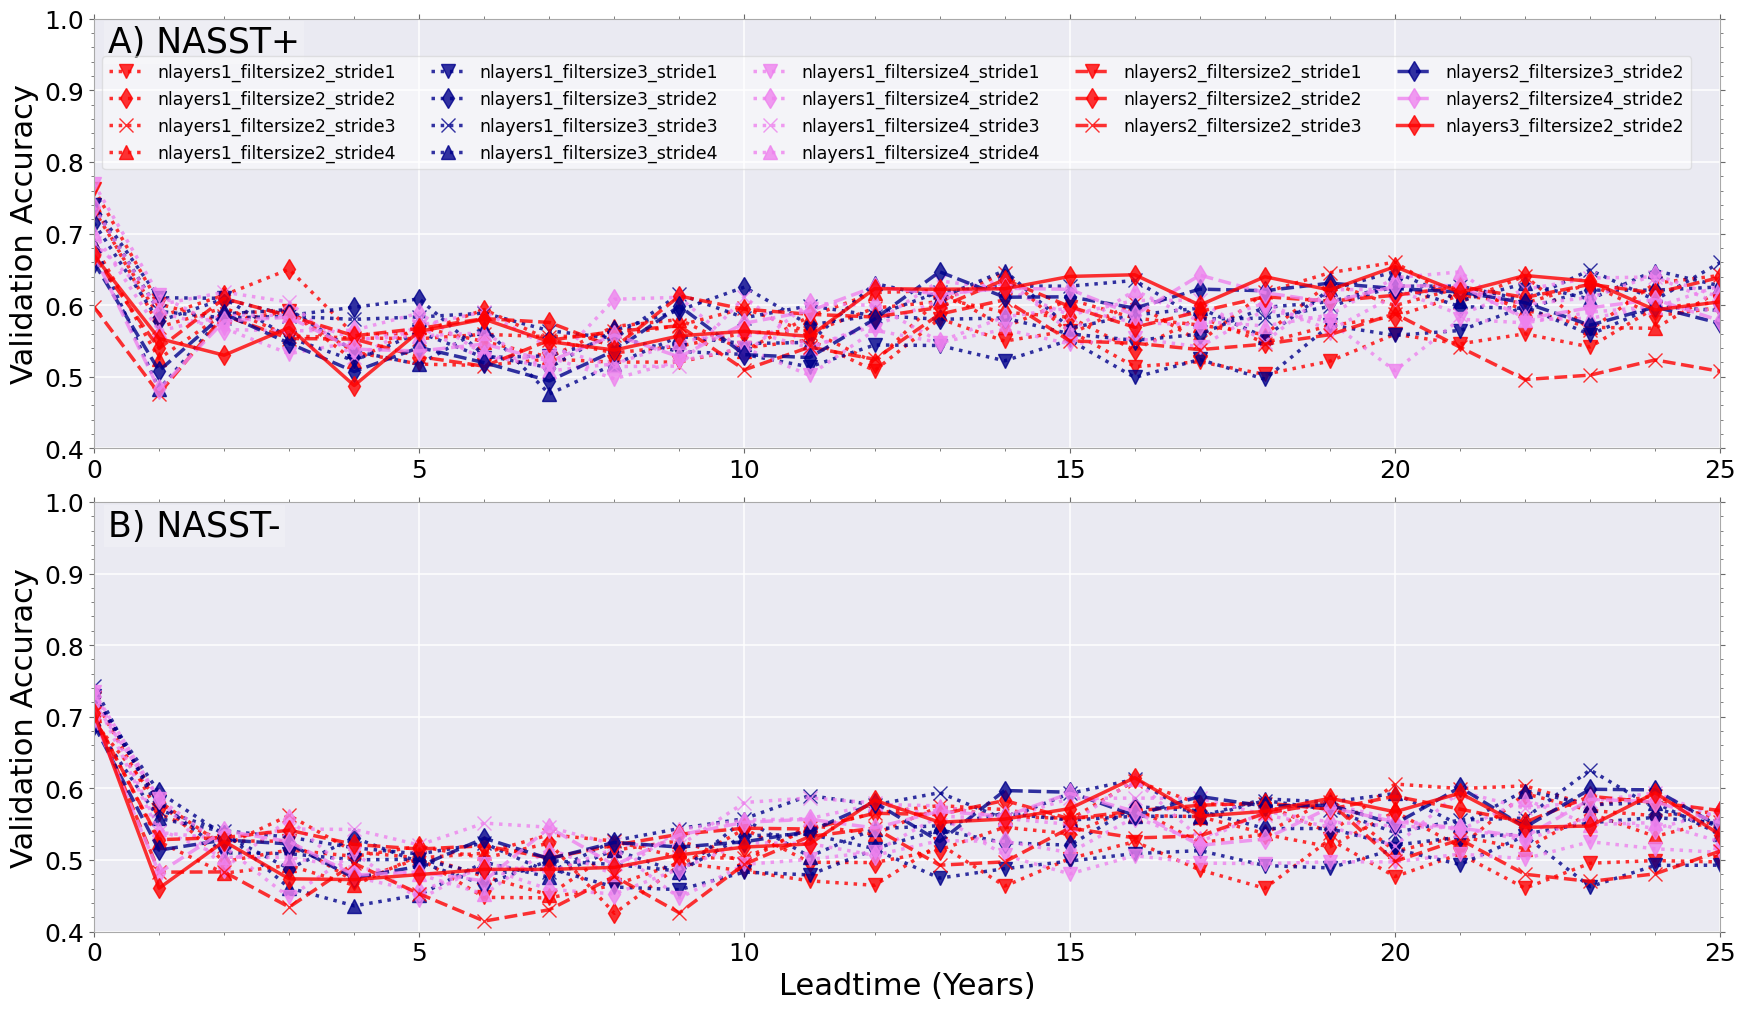

In [129]:

fig,axs = plt.subplots(2,1,constrained_layout=True,figsize=(18,10))

class_choose=[0,2]
for a in range(2):
    iclass = class_choose[a]
    
    ax = axs[a]
    if iclass in [0,2]:
        xlm = [0.4,1]
    else:
        xlm = [0,1]
    
    ax = viz.add_ticks(ax,facecolor="#eaeaf2",grid_lw=1.5,grid_col="w",grid_ls="solid",
                    spinecolor="darkgray",tickcolor="dimgray",
                    ticklabelcolor="k",fontsize=18)
    
        
    viz.label_sp(splabels_class2[a],labelstyle="%s",usenumber=True,
                 ax=ax,fig=fig,fontsize=25,
             alpha=0.2,x=0.)
    
    for nc in range(ncombos):
        
        alpha = 1
        plot_acc = cnn_accs_all[nc,:,:,iclass].mean(0)
        lbl      = cnn_combo_names[nc].replace("_dropoutFalse","")
        
        
        if "nlayers1" in lbl:
            #c="red"
            #marker = "x"
            ls = "dotted"
        elif "nlayers2" in lbl:
            #c='darkblue'
            #marker="."
            ls = "dashed"
        elif "nlayers3" in lbl:
            #c='violet'
            #marker="d"
            ls = "solid"
            
        if "filtersize2" in lbl:
            c="red"
            #ls = "dotted"
        elif "filtersize3" in lbl:
            c='darkblue'
            #ls = "dashed"
        elif "filtersize4" in lbl:
            c='violet'
           # ls = "solid"
            
        
        if "stride1" in lbl:
            marker="v"
            #c = "red"
        elif "stride2" in lbl:
            marker="d"
            #c = "gold"
        elif "stride3" in lbl:
            marker="x"
            #c = "blue"
        elif "stride4" in lbl:
            marker="^"
            #c = "magenta"
            
        # if ("stride1" in lbl) and ("filtersize2" in lbl) and ("nlayers2" in lbl):
        #     print(nc)
        #     c = 'k'
        
        ax.plot(leads,plot_acc,label=lbl,ls=ls,marker=marker,lw=2.5,c=c,markersize=10,alpha=0.8)
    
    #ax.set_title("Predictor: %s, Class: %s" % (varname,pparams.classes[iclass]))
    ax.set_ylim([xlm[0],xlm[-1]])
    ax.set_xlim([0,25])
    #ax.axhline([.6],label="Original Acc. (PaperRun)",color="k",ls='dashed')
    ax.set_ylabel("Validation Accuracy",fontsize=22)
    if a == 0:
        ax.legend(ncol=5,fontsize=12.5,loc=(.005,.65),framealpha=0.5)
    elif a == 1:
        ax.set_xlabel("Leadtime (Years)",fontsize=22)

if pubready:
    print("Saving Figure S3!")
    savename = "%sFigureS3_CNN_Hyperparameter_Testing.pdf" % (figpath)
    proc.savefig_pub(savename,fig,format='pdf')
else:
    savename = "%sCNN2_ParamTesting_%s_classPosNeg.png" % (figpath,varname)
    plt.savefig(savename,dpi=150,bbox_inches='tight')